In [1]:
import matplotlib.pyplot as plt
from helper_func import *

We start by using the ```get_data()``` function from the ```helper_func``` module, which uses the [pandas-datareader package](https://pandas-datareader.readthedocs.io/en/latest/) to load daily stock data and then plot the **closing prices**.

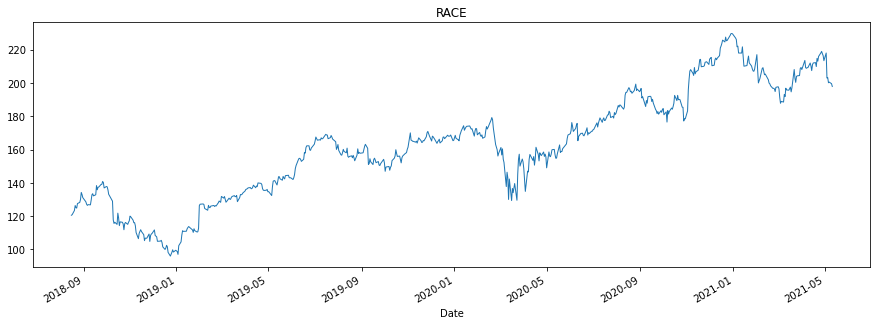

In [2]:
ticker = 'race'
time_window = 1000

stock = get_data(ticker, time_window)

plt.figure(figsize=(15,5))
stock.Close.plot(lw=1)
plt.title(f'{ticker.upper()}')
plt.show()

Let's see what happens if we try to use **clustering** directly on the observed data *without* any smoothing applied. We use the ```plot_trend()``` function to plot the data.

First, we evaluate the [logarithmic return](https://en.wikipedia.org/wiki/Rate_of_return#Comparing_ordinary_return_with_logarithmic_return) (```lr```), which has some useful properties; we can do it at once with [```np.diff```](https://numpy.org/doc/stable/reference/generated/numpy.diff.html).

We then fit the k-means clustering algorithm, feeding ```lr``` as training instances. We also need to reshape the data, as this expects a 2D array.

In [3]:
c = stock.Close.values
lr = np.diff(np.log(c))

km_obs = KMeans(n_clusters=3).fit(lr.reshape(-1,1))

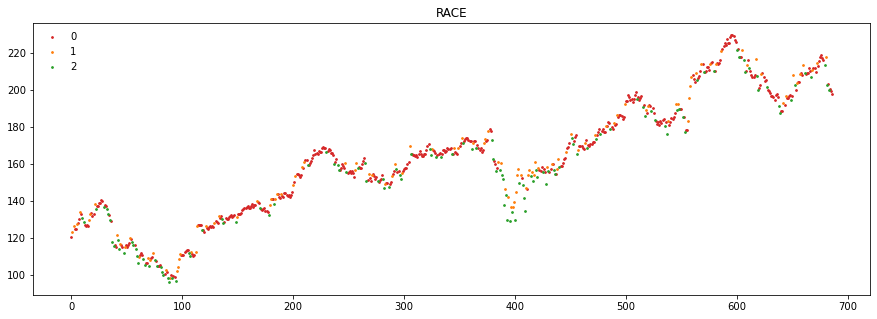

In [4]:
xr = np.arange(len(lr))
y = c[1:]    # because len(c) = len(lr) + 1 (due to subtraction)
labels = km_obs.labels_

plot_trend(xr, y, labels, ticker)

Not a great help, without smoothing the time series: rough data lead to rough log-returns, which makes it very difficult for a clustering algorithm to separate the data.

We now apply a smoothing technique. Many of these exist; we will consider a **forward-backward EMA** (Exponential Moving Average). What does this mean? Let's break it down:
- *EMA* gives more weight to recent prices, as a result of which it can better capture the underlying trend in a faster way; with EMA old data points never leave the average, retaining a multiplier (albeit declining to zero) even if they are outside of the chosen time span. However, to *classify* trends well, the lag of regular moving averages is too significant.
- *Forward-backward filtering* is a heavily used method in digital signal processing, which consists of applying a filter forward in time, then apply it once again backward. We apply a filter twice, hence the result is a two-passes filter, which results in an even smoother output -- more precisely, the filter [amplitude response is squared](https://ccrma.stanford.edu/~jos/fp/Forward_Backward_Filtering.html).

It is important to understand that we are **not predicting anything** here: we just need indexes that tell us something about our data, so we can separate it -- and analyse it further.

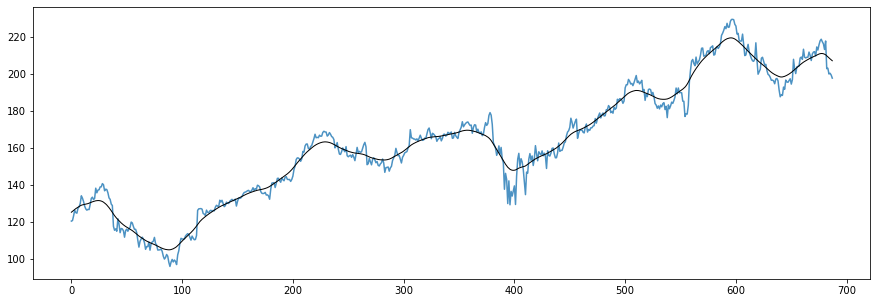

In [5]:
cs = stock.Close

# forward and forward-backward EMAs
f_ema = cs.ewm(span=20).mean()
fb_ema = f_ema[::-1].ewm(span=20).mean()[::-1]

plt.figure(figsize=(15,5))
plt.plot(stock.Close.values, c='tab:blue', alpha=0.8)
plt.plot(fb_ema.values, c='k', lw=1)
plt.show()

This looks pretty **smooth** and with **no lag**. We can use the ```get_trend()``` function, which simply puts all the pieces together.

In [6]:
c = stock.Close.values
x, EMA, labels = get_trend(c)
yy = c[1:]

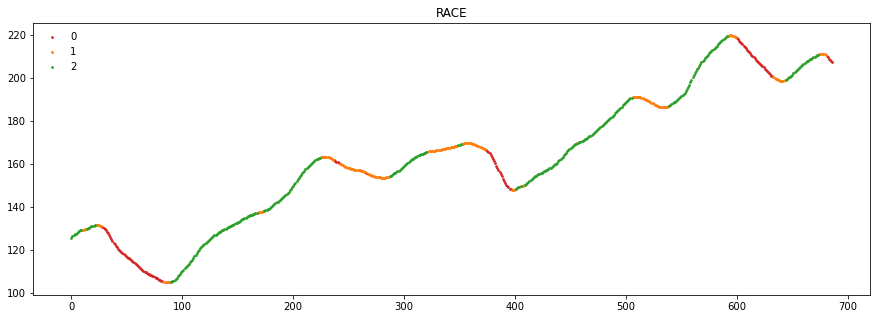

In [7]:
plot_trend(x, EMA, labels, ticker)

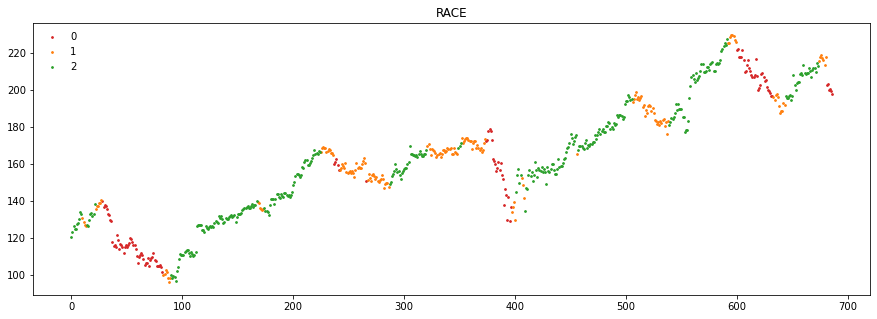

In [8]:
plot_trend(x, yy, labels, ticker)

It looks like it worked pretty well! From here, one could separate and analyse *by label*.

In [9]:
up = len(labels[labels == 2])
down = len(labels[labels == 0])
still = len(labels[labels == 1])

days = up + down + still

up_perc = 100 * up / days
down_perc = 100 * down / days
still_perc = 100 - up_perc - down_perc

print(f'The {ticker.upper()} stock has been on an up-trend for {round(up_perc,1)}% of the time, on an down-trend for {round(down_perc,1)}% of the time')

The RACE stock has been on an up-trend for 53.6% of the time, on an down-trend for 17.9% of the time


We can finally put all the relevant images together, also relabelling the points to make them fall into three categories: *bullish*, *bearish* and *steady*.

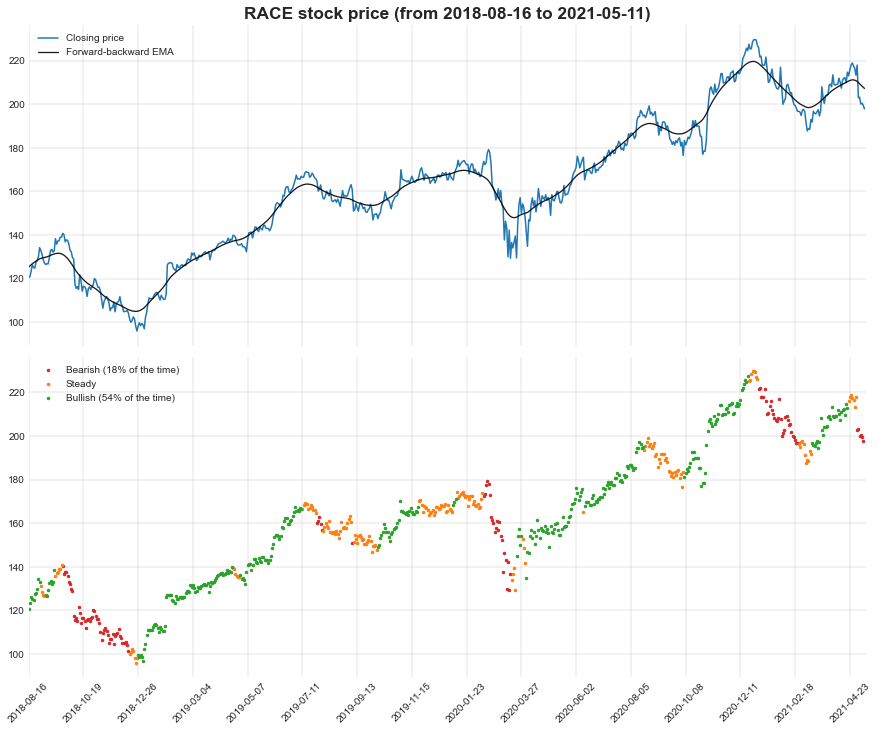

In [10]:
colors = ['tab:red','tab:orange','tab:green']
nclass = 3
freq_tic = int(len(stock.Close.values) / 15)
first_day, last_day = stock.Close.index.strftime('%Y-%m-%d').values[0], stock.Close.index.strftime('%Y-%m-%d').values[-1]

with plt.style.context('seaborn-white'):
    # Figure
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,
                                   gridspec_kw = {'hspace':0.035}, figsize=(15,12))
    
    # Upper figure
    f_ema = cs.ewm(span=20).mean()
    fb_ema = f_ema[::-1].ewm(span=20).mean()[::-1]
    ax1.plot(stock.Close.values, c='tab:blue', alpha=1, label='Closing price')
    ax1.plot(fb_ema.values, c='k', alpha=0.9, lw=1.3, label='Forward-backward EMA')
    ax1.legend(frameon=False)
    ax1.grid(color='gray', linestyle='-', linewidth=0.2)
    [s.set_visible(False) for s in ax1.spines.values()]
    
    # Lower figure
    for i in range(nclass):
        xx = x[labels == i]
        yy = y[labels == i]
        ax2.scatter(xx, yy, c=colors[i], s=6, label=i)
    handles, new_labels = ax2.get_legend_handles_labels()
    new_labels = [f'Bearish ({int(round(down_perc,0))}% of the time)', 'Steady', f'Bullish ({int(round(up_perc,0))}% of the time)']
    ax2.legend(handles, new_labels, frameon=False)
    ax2.grid(color='gray', linestyle='-', linewidth=0.2)
    [s.set_visible(False) for s in ax2.spines.values()]
    
    ax1.set_title(f'{ticker.upper()} stock price (from {first_day} to {last_day})', fontsize='xx-large', weight='bold')
    ax1.set_xlim(0, len(stock.Close.values))
    ax2.set_xticks(range(0, len(stock.Close.values), freq_tic))
    ax2.set_xticklabels(stock.Close.index.strftime('%Y-%m-%d').values[::freq_tic], rotation = 45)
    plt.savefig(f'{ticker.upper()}_combined.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()